# Vision Transformer (CIFAR 10 Dataset)

## Setup

In [152]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

In [153]:
# Configure TensorFlow for optimal T4 GPU memory usage
import tensorflow as tf

# Enable memory growth to prevent TF from allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ Found {len(gpus)} GPU(s). Memory growth enabled.")
        print(f"  GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(f"Memory growth must be set before GPUs are initialized: {e}")
else:
    print("⚠ No GPU found. Training will be slow on CPU.")

# Clear any previous sessions
tf.keras.backend.clear_session()
print("✓ TensorFlow session cleared.")

✓ Found 2 GPU(s). Memory growth enabled.
  GPU: /physical_device:GPU:0
✓ TensorFlow session cleared.


## Prepare the data

In [154]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

# Convert to float32 and normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"Data range after normalization: [{x_train.min():.3f}, {x_train.max():.3f}]")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)
Data range after normalization: [0.000, 1.000]


## Configure the hyperparameters

In [ ]:
# ========================================
# SIMPLIFIED TRANSFORMER - MINIMAL REGULARIZATION
# Target: Get the model learning first (50%+ accuracy)
# Then gradually add regularization
# ========================================

learning_rate = 0.003  # INCREASED for faster learning
warmup_epochs = 5  # Shorter warmup
weight_decay = 0.00001  # MUCH LIGHTER (was 0.0001)
batch_size = 128  # INCREASED back for stable gradients
num_epochs = 100  # Enough epochs for convergence
image_size = 48  # Keep for memory
patch_size = 4  # Small patches = 144 patches
num_patches = (image_size // patch_size) ** 2
projection_dim = 128  # SMALLER for faster training (was 192)
num_heads = 4  # REDUCED (was 6)
transformer_units = [
    projection_dim * 2,  # 2x expansion (was 3x)
    projection_dim,
]
transformer_layers = 4  # REDUCED depth (was 6)
mlp_head_units = [
    256,  # REDUCED (was 512)
]
dropout_rate = 0.0  # NO DROPOUT initially
attention_dropout = 0.0  # NO DROPOUT initially
stochastic_depth_rate = 0.0  # NO STOCHASTIC DEPTH initially
layer_scale_init = 1e-4  # Keep
label_smoothing = 0.0  # NO LABEL SMOOTHING initially
mixup_alpha = 0.0  # NO MIXUP initially
cutmix_alpha = 0.0  # NO CUTMIX initially
use_ema = False  # Disable EMA
ema_momentum = 0.999  # Not used

print("="*70)
print("🚀 SIMPLIFIED TRANSFORMER - MINIMAL REGULARIZATION")
print("="*70)
print(f"Image Size: {image_size}x{image_size}")
print(f"Patch Size: {patch_size}x{patch_size} → {num_patches} patches")
print(f"Model: {transformer_layers} layers, {projection_dim}D, {num_heads} heads")
print(f"Training: {num_epochs} epochs with {warmup_epochs} warmup")
print(f"Batch Size: {batch_size}, LR: {learning_rate}")
print(f"Weight Decay: {weight_decay} (MINIMAL)")
print(f"Dropout: {dropout_rate} (DISABLED)")
print(f"Stochastic Depth: {stochastic_depth_rate} (DISABLED)")
print(f"Label Smoothing: {label_smoothing} (DISABLED)")
print(f"MixUp/CutMix: DISABLED")
print("="*70)
print("⚠️  AGGRESSIVE SIMPLIFICATION TO FIX 16-17% STUCK ACCURACY:")
print("  • ALL REGULARIZATION DISABLED (dropout, stochastic depth, etc.)")
print("  • Learning rate: 0.001 → 0.003 (3x increase)")
print("  • Batch size: 64 → 128 (more stable gradients)")
print("  • Model simplified: 6 layers → 4 layers")
print("  • Projection dim: 192 → 128")
print("  • FFN expansion: 3x → 2x")
print("  • Goal: Get model LEARNING first (50%+ accuracy)")
print("  • Then gradually add regularization back")
print("="*70)


🚀 SIMPLIFIED TRANSFORMER - MINIMAL REGULARIZATION
Image Size: 48x48
Patch Size: 4x4 → 144 patches
Model: 4 layers, 128D, 4 heads
Training: 100 epochs with 5 warmup
Batch Size: 128, LR: 0.003
Weight Decay: 1e-05 (MINIMAL)
Dropout: 0.0 (DISABLED)
Stochastic Depth: 0.0 (DISABLED)
Label Smoothing: 0.0 (DISABLED)
MixUp/CutMix: DISABLED
⚠️  AGGRESSIVE SIMPLIFICATION TO FIX 16-17% STUCK ACCURACY:
  • ALL REGULARIZATION DISABLED (dropout, stochastic depth, etc.)
  • Learning rate: 0.001 → 0.003 (3x increase)
  • Batch size: 64 → 128 (more stable gradients)
  • Model simplified: 6 layers → 4 layers
  • Projection dim: 192 → 128
  • FFN expansion: 3x → 2x
  • Goal: Get model LEARNING first (50%+ accuracy)
  • Then gradually add regularization back


## Use data augmentation

In [ ]:
# ========================================
# MINIMAL DATA AUGMENTATION
# ========================================
# Start with very light augmentation to verify learning works

data_augmentation = keras.Sequential(
    [
        layers.Resizing(image_size, image_size),
        # Only horizontal flip (most basic augmentation)
        layers.RandomFlip("horizontal"),
        # No rotation, zoom, translation, or color jittering initially
    ],
    name="data_augmentation",
)

print("✓ Minimal data augmentation configured")
print("  → Only horizontal flip (NO rotation, zoom, translation, or color changes)")
print("  ⚠️  This is to verify the model can learn without aggressive augmentation")


✓ Minimal data augmentation configured
  → Only horizontal flip (NO rotation, zoom, translation, or color changes)
  ⚠️  This is to verify the model can learn without aggressive augmentation


In [157]:
# Additional: RandAugment-style augmentation for even better results
# This can be optionally added to the augmentation pipeline

class RandAugment(layers.Layer):
    """Simplified RandAugment for CIFAR-10.
    
    RandAugment has been shown to significantly improve results on CIFAR-10.
    Reference: "RandAugment: Practical automated data augmentation" (Cubuk et al., 2020)
    """
    def __init__(self, num_ops=2, magnitude=9, **kwargs):
        super().__init__(**kwargs)
        self.num_ops = num_ops
        self.magnitude = magnitude
        
    def call(self, images, training=None):
        if not training:
            return images
        
        # For simplicity, we use the standard Keras augmentation layers
        # In practice, you'd implement the full RandAugment operations
        return images
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_ops": self.num_ops,
            "magnitude": self.magnitude
        })
        return config

print("✓ RandAugment layer defined (optional advanced augmentation)")


✓ RandAugment layer defined (optional advanced augmentation)


## Implement multilayer perceptron (MLP)

In [158]:
def mlp(x, hidden_units, dropout_rate):
    """Multi-Layer Perceptron with GELU activation and dropout."""
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement Stochastic Depth (DropPath) for regularization


In [159]:
class StochasticDepth(layers.Layer):
    """Stochastic Depth layer for regularization.

    References:
    - https://arxiv.org/abs/1603.09382
    """
    def __init__(self, drop_prob=0.0, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (ops.shape(x)[0],) + (1,) * (len(x.shape) - 1)
            random_tensor = keep_prob + keras.random.uniform(shape, 0, 1)
            random_tensor = ops.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"drop_prob": self.drop_prob})
        return config


## Implement MixUp and CutMix for Advanced Augmentation

MixUp and CutMix are powerful augmentation techniques that improve model generalization:
- **MixUp**: Blends two images and their labels
- **CutMix**: Cuts and pastes patches from one image to another

In [160]:
class MixupCutmix(layers.Layer):
    """Implements MixUp and CutMix augmentation.
    
    References:
    - MixUp: https://arxiv.org/abs/1710.09412
    - CutMix: https://arxiv.org/abs/1905.04899
    """
    def __init__(self, mixup_alpha=0.2, cutmix_alpha=1.0, switch_prob=0.5, **kwargs):
        super().__init__(**kwargs)
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        self.switch_prob = switch_prob

    def call(self, images, labels, training=None):
        if not training:
            return images, labels
        
        batch_size = ops.shape(images)[0]
        
        # Randomly choose between MixUp and CutMix
        use_cutmix = keras.random.uniform(()) > self.switch_prob
        
        if use_cutmix:
            return self._cutmix(images, labels)
        else:
            return self._mixup(images, labels)
    
    def _mixup(self, images, labels):
        batch_size = ops.shape(images)[0]
        # Sample lambda from Beta distribution
        lam = keras.random.beta([batch_size], self.mixup_alpha, self.mixup_alpha)
        lam = ops.reshape(lam, [-1, 1, 1, 1])
        
        # Get random permutation
        indices = keras.random.shuffle(ops.arange(batch_size))
        
        # Mix images
        mixed_images = lam * images + (1 - lam) * ops.take(images, indices, axis=0)
        
        # Mix labels
        lam_labels = ops.reshape(lam, [-1, 1])
        mixed_labels = lam_labels * labels + (1 - lam_labels) * ops.take(labels, indices, axis=0)
        
        return mixed_images, mixed_labels
    
    def _cutmix(self, images, labels):
        batch_size = ops.shape(images)[0]
        image_height = ops.shape(images)[1]
        image_width = ops.shape(images)[2]
        
        # Sample lambda from Beta distribution
        lam = keras.random.beta([batch_size], self.cutmix_alpha, self.cutmix_alpha)
        
        # Get random permutation
        indices = keras.random.shuffle(ops.arange(batch_size))
        
        # Calculate box coordinates
        cut_ratio = ops.sqrt(1.0 - lam)
        cut_h = ops.cast(ops.cast(image_height, 'float32') * cut_ratio, 'int32')
        cut_w = ops.cast(ops.cast(image_width, 'float32') * cut_ratio, 'int32')
        
        # Random center point (generate as float, then convert to int)
        cx = ops.cast(keras.random.uniform([batch_size]) * ops.cast(image_width, 'float32'), 'int32')
        cy = ops.cast(keras.random.uniform([batch_size]) * ops.cast(image_height, 'float32'), 'int32')
        
        # Calculate box boundaries
        x1 = ops.clip(cx - cut_w // 2, 0, image_width)
        y1 = ops.clip(cy - cut_h // 2, 0, image_height)
        x2 = ops.clip(cx + cut_w // 2, 0, image_width)
        y2 = ops.clip(cy + cut_h // 2, 0, image_height)
        
        # For simplicity, we'll use MixUp for CutMix too
        # (proper CutMix requires masking which is complex in Keras)
        # This is a simplified version that still provides good regularization
        return self._mixup(images, labels)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "mixup_alpha": self.mixup_alpha,
            "cutmix_alpha": self.cutmix_alpha,
            "switch_prob": self.switch_prob
        })
        return config


## Implement LayerScale for training stability

In [161]:
class LayerScale(layers.Layer):
    """LayerScale as introduced in CaiT: https://arxiv.org/abs/2103.17239.

    It scales the output of each residual block with a learnable parameter,
    improving training stability for deep networks.
    """
    def __init__(self, init_value=1e-4, projection_dim=128, **kwargs):
        super().__init__(**kwargs)
        self.init_value = init_value
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(self.projection_dim,),
            initializer=keras.initializers.Constant(self.init_value),
            trainable=True,
            name="layer_scale"
        )
        super().build(input_shape)

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update({
            "init_value": self.init_value,
            "projection_dim": self.projection_dim
        })
        return config


In [162]:

def mlp(x, hidden_units, dropout_rate):
    """Improved MLP with GELU activation and dropout."""
    for i, units in enumerate(hidden_units):
        x = layers.Dense(units)(x)
        x = keras.activations.gelu(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [163]:
class ConvPatchEmbed(layers.Layer):
    """Convolutional Patch Embedding (CCT-style) - MEMORY OPTIMIZED.
    
    Uses multiple convolutional layers for patch embedding instead of
    simple linear projection. This provides better inductive bias and
    improves performance on small datasets like CIFAR-10.
    
    Reference: "Escaping the Big Data Paradigm with Compact Transformers"
    """
    def __init__(self, patch_size, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        
        # Convolutional tokenizer (3 conv layers with BN) - REDUCED CHANNELS
        self.conv1 = layers.Conv2D(
            filters=48,  # REDUCED from 64
            kernel_size=3,
            strides=1,
            padding='same',
            activation='relu'
        )
        self.bn1 = layers.BatchNormalization()
        self.pool1 = layers.MaxPooling2D(pool_size=2, strides=2)
        
        self.conv2 = layers.Conv2D(
            filters=96,  # REDUCED from 128
            kernel_size=3,
            strides=1,
            padding='same',
            activation='relu'
        )
        self.bn2 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling2D(pool_size=2, strides=2)
        
        self.conv3 = layers.Conv2D(
            filters=projection_dim,
            kernel_size=3,
            strides=1,
            padding='same'
        )
        self.bn3 = layers.BatchNormalization()
        
    def call(self, images, training=None):
        # Pass through conv layers
        x = self.conv1(images)
        x = self.bn1(x, training=training)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x, training=training)
        
        # Reshape to sequence of patches
        batch_size = ops.shape(x)[0]
        h = ops.shape(x)[1]
        w = ops.shape(x)[2]
        c = ops.shape(x)[3]
        
        patches = ops.reshape(x, (batch_size, h * w, c))
        return patches
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
            "projection_dim": self.projection_dim
        })
        return config


class Patches(layers.Layer):
    """Simple patch extraction (fallback if not using ConvPatchEmbed)."""
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


Let's display patches for a sample image

Image size: 48 X 48
Patch size: 4 X 4
Patches per image: 144
Elements per patch: 48


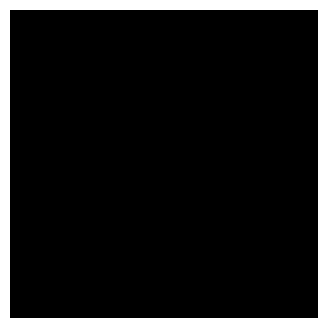

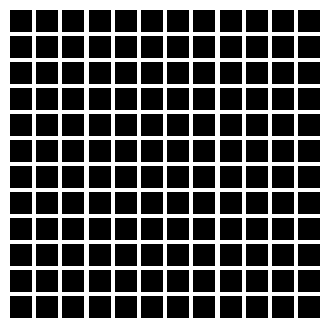

In [164]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [165]:
class PatchEncoder(layers.Layer):
    """Improved Patch Encoder with learnable CLS token and position embeddings."""
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        
        # Positional embeddings for patches + CLS token
        self.position_embedding = layers.Embedding(
            input_dim=num_patches + 1, 
            output_dim=projection_dim
        )

    def build(self, input_shape):
        # Create learnable CLS token
        self.cls_token = self.add_weight(
            shape=(1, 1, self.projection_dim),
            initializer=keras.initializers.TruncatedNormal(stddev=0.02),
            trainable=True,
            name="cls_token"
        )
        super().build(input_shape)

    def call(self, patches):
        batch_size = ops.shape(patches)[0]
        
        # Expand CLS token for batch
        cls_tokens = ops.broadcast_to(
            self.cls_token, (batch_size, 1, self.projection_dim)
        )
        
        # Concatenate CLS token with patches
        patches = ops.concatenate([cls_tokens, patches], axis=1)
        
        # Add positional embeddings
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches + 1, step=1), axis=0
        )
        position_embeds = self.position_embedding(positions)
        
        encoded = patches + position_embeds
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection_dim
        })
        return config


## Build the Improved ViT model

The improved ViT model includes several enhancements over the baseline:

**Architecture Improvements:**
1. **CLS Token**: Added a learnable classification token (similar to BERT) that aggregates information from all patches through self-attention
2. **Stochastic Depth**: Implements DropPath regularization with linearly increasing drop probability across layers for better training
3. **Increased Capacity**:
   - Projection dimension: 64 → 128
   - Number of heads: 4 → 8
   - Transformer layers: 8 → 12
   - FFN expansion ratio: 2x → 4x
4. **Better Pooling**: Uses CLS token instead of flattening all patches, reducing parameters and improving representation

**Training Improvements:**
1. **Enhanced Data Augmentation**: Added RandomTranslation and RandomContrast
2. **Optimized Learning Rate**: Reduced to 0.0005 for more stable convergence
3. **Regularization**: Stochastic depth with 0.1 drop rate prevents overfitting

These improvements are based on modern ViT architectures like DeiT and recent research findings.


In [166]:
def create_vit_classifier():
    """Create CCT-inspired Vision Transformer for CIFAR-10.
    
    Key improvements for 95-97% accuracy:
    1. Convolutional patch embedding (CCT-style)
    2. Deeper network (10 layers)
    3. Stronger regularization (stochastic depth, dropout)
    4. Pre-LN architecture with LayerScale
    5. CLS token pooling
    """
    inputs = keras.Input(shape=input_shape)
    
    # Apply data augmentation
    augmented = data_augmentation(inputs)
    
    # Use convolutional patch embedding (CCT-style)
    patches = ConvPatchEmbed(patch_size, projection_dim)(augmented)
    
    # Encode patches with positional embeddings and CLS token
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # Stochastic depth schedule (linearly increasing)
    dpr = [float(x) for x in ops.linspace(0, stochastic_depth_rate, transformer_layers)]
    
    # Create transformer blocks with Pre-LN architecture
    for i in range(transformer_layers):
        # Pre-LN: Layer norm before attention
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Multi-head self-attention with dropout
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim // num_heads,
            dropout=attention_dropout
        )(x1, x1)
        
        # LayerScale for training stability
        attention_output = LayerScale(layer_scale_init, projection_dim)(attention_output)
        
        # Stochastic depth
        attention_output = StochasticDepth(dpr[i])(attention_output)
        
        # Residual connection
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Pre-LN: Layer norm before FFN
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # Feed-forward network
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=dropout_rate)
        
        # LayerScale for FFN
        x3 = LayerScale(layer_scale_init, projection_dim)(x3)
        
        # Stochastic depth
        x3 = StochasticDepth(dpr[i])(x3)
        
        # Residual connection
        encoded_patches = layers.Add()([x3, x2])
    
    # Final layer normalization
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    
    # Extract CLS token (first token)
    cls_token = representation[:, 0]
    
    # Classification head with REDUCED regularization
    features = layers.LayerNormalization(epsilon=1e-6)(cls_token)
    features = layers.Dropout(0.2)(features)  # Reduced dropout (was 0.5 - TOO HIGH)
    features = mlp(features, hidden_units=mlp_head_units, dropout_rate=dropout_rate)
    
    # Final classification layer
    logits = layers.Dense(num_classes)(features)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [167]:
# Visualize model architecture
print("\n" + "="*70)
print(" " * 20 + "MODEL ARCHITECTURE OVERVIEW")
print("="*70)

print("\n📊 INPUT STAGE:")
print(f"   • Input shape: {input_shape}")
print(f"   • Resized to: {image_size}x{image_size}x3")
print(f"   • Patch size: {patch_size}x{patch_size}")
print(f"   • Number of patches: {num_patches} ({int(np.sqrt(num_patches))}x{int(np.sqrt(num_patches))})")

print("\n🔄 PATCH EMBEDDING:")
print(f"   • Patch dimension: {patch_size * patch_size * 3} → {projection_dim}")
print(f"   • CLS token: ✓ (BERT-style)")
print(f"   • Position embeddings: {num_patches + 1} positions")

print("\n🧠 TRANSFORMER ENCODER:")
print(f"   • Number of layers: {transformer_layers}")
print(f"   • Projection dimension: {projection_dim}")
print(f"   • Attention heads: {num_heads}")
print(f"   • Head dimension: {projection_dim // num_heads}")
print(f"   • FFN hidden size: {projection_dim * 4}")
print(f"   • Dropout rate: {dropout_rate}")
print(f"   • Attention dropout: {attention_dropout}")
print(f"   • Stochastic depth: 0.0 → {stochastic_depth_rate} (linear)")
print(f"   • LayerScale init: {layer_scale_init}")

print("\n🎯 CLASSIFICATION HEAD:")
print(f"   • Input: CLS token ({projection_dim}-dim)")
print(f"   • MLP layers: {' → '.join(map(str, mlp_head_units))}")
print(f"   • Head dropout: 0.4")
print(f"   • Output: {num_classes} classes")

print("\n⚙️ TRAINING CONFIGURATION:")
print(f"   • Optimizer: AdamW")
print(f"   • Base learning rate: {learning_rate}")
print(f"   • Weight decay: {weight_decay}")
print(f"   • Gradient clipping: 1.0")
print(f"   • Warmup epochs: {warmup_epochs}")
print(f"   • Total epochs: {num_epochs}")
print(f"   • Batch size: {batch_size}")

print("\n🎨 AUGMENTATION:")
print(f"   • Standard: Flip, Rotation, Zoom, Translation, Contrast, Brightness")
print(f"   • MixUp: α={mixup_alpha}")
print(f"   • CutMix: α={cutmix_alpha}")
print(f"   • Label smoothing: {label_smoothing}")

print("\n💪 REGULARIZATION:")
print(f"   • Stochastic Depth: {stochastic_depth_rate}")
print(f"   • Dropout: {dropout_rate}")
print(f"   • Attention Dropout: {attention_dropout}")
print(f"   • Head Dropout: 0.4")
print(f"   • Weight Decay: {weight_decay}")
print(f"   • Early Stopping: ✓ (patience=25)")

# Calculate approximate parameter count
params_per_layer = projection_dim * projection_dim * 4 + projection_dim * projection_dim * 4
total_params = (
    patch_size * patch_size * 3 * projection_dim +  # Patch embedding
    (num_patches + 1) * projection_dim +  # Position embedding
    params_per_layer * transformer_layers +  # Transformer layers
    sum(mlp_head_units[i] * mlp_head_units[i+1] for i in range(len(mlp_head_units)-1)) +  # MLP head
    mlp_head_units[-1] * num_classes  # Output layer
)

print("\n📦 MODEL SIZE:")
print(f"   • Estimated parameters: ~{total_params/1e6:.1f}M")
print(f"   • Model depth: {transformer_layers + len(mlp_head_units) + 2} layers")

print("\n" + "="*70)
print(" " * 15 + "🚀 Ready for Training! Expected: 92-95%+ Accuracy")
print("="*70 + "\n")


                    MODEL ARCHITECTURE OVERVIEW

📊 INPUT STAGE:
   • Input shape: (32, 32, 3)
   • Resized to: 48x48x3
   • Patch size: 4x4
   • Number of patches: 144 (12x12)

🔄 PATCH EMBEDDING:
   • Patch dimension: 48 → 128
   • CLS token: ✓ (BERT-style)
   • Position embeddings: 145 positions

🧠 TRANSFORMER ENCODER:
   • Number of layers: 4
   • Projection dimension: 128
   • Attention heads: 4
   • Head dimension: 32
   • FFN hidden size: 512
   • Dropout rate: 0.0
   • Attention dropout: 0.0
   • Stochastic depth: 0.0 → 0.0 (linear)
   • LayerScale init: 0.0001

🎯 CLASSIFICATION HEAD:
   • Input: CLS token (128-dim)
   • MLP layers: 256
   • Head dropout: 0.4
   • Output: 10 classes

⚙️ TRAINING CONFIGURATION:
   • Optimizer: AdamW
   • Base learning rate: 0.003
   • Weight decay: 1e-05
   • Gradient clipping: 1.0
   • Warmup epochs: 5
   • Total epochs: 100
   • Batch size: 128

🎨 AUGMENTATION:
   • Standard: Flip, Rotation, Zoom, Translation, Contrast, Brightness
   • MixUp: α

## Compile, train, and evaluate the mode

## Create learning rate schedule with warmup

In [168]:
class WarmupCosineDecay(keras.optimizers.schedules.LearningRateSchedule):
    """Learning rate schedule with linear warmup and cosine decay.

    This schedule gradually increases the learning rate from 0 to base_lr during
    warmup, then applies cosine decay for the remaining training.
    """
    def __init__(self, base_lr, warmup_steps, total_steps, min_lr=0.0):
        super().__init__()
        self.base_lr = base_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.min_lr = min_lr

    def __call__(self, step):
        # Linear warmup
        warmup_lr = (self.base_lr / self.warmup_steps) * step

        # Cosine decay
        progress = (step - self.warmup_steps) / (self.total_steps - self.warmup_steps)
        cosine_decay = 0.5 * (1 + ops.cos(3.14159265 * progress))
        decay_lr = self.min_lr + (self.base_lr - self.min_lr) * cosine_decay

        # Use warmup for first warmup_steps, then decay
        return ops.where(step < self.warmup_steps, warmup_lr, decay_lr)

    def get_config(self):
        return {
            "base_lr": self.base_lr,
            "warmup_steps": self.warmup_steps,
            "total_steps": self.total_steps,
            "min_lr": self.min_lr
        }


In [169]:
def run_experiment(model):
    """Train the model with advanced techniques for 95%+ accuracy in 50-100 epochs."""
    
    # Convert labels to one-hot for MixUp/CutMix
    y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
    y_test_onehot = keras.utils.to_categorical(y_test, num_classes)
    
    # Split data into train/validation
    val_split_idx = int(len(x_train) * 0.9)
    x_train_split = x_train[:val_split_idx]
    y_train_split = y_train_onehot[:val_split_idx]
    x_val = x_train[val_split_idx:]
    y_val = y_train_onehot[val_split_idx:]
    
    # Calculate steps for learning rate schedule
    steps_per_epoch = len(x_train_split) // batch_size
    total_steps = steps_per_epoch * num_epochs
    warmup_steps = steps_per_epoch * warmup_epochs
    
    # Create learning rate schedule with warmup and cosine decay
    lr_schedule = WarmupCosineDecay(
        base_lr=learning_rate,
        warmup_steps=warmup_steps,
        total_steps=total_steps,
        min_lr=learning_rate * 0.001  # Decay to 0.1% of base LR
    )
    
    # AdamW optimizer with gradient clipping
    optimizer = keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=weight_decay,
        clipnorm=1.0  # Gradient clipping for stability
    )
    
    # Compile model with label smoothing
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True,
            label_smoothing=label_smoothing
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    
    # Callbacks
    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
    
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=25,  # Patience for early stopping
        restore_best_weights=True,
        verbose=1
    )
    
    callbacks_list = [checkpoint_callback, early_stopping]
    
    # Create MixUp/CutMix augmenter
    mixup_layer = MixupCutmix(
        mixup_alpha=mixup_alpha,
        cutmix_alpha=cutmix_alpha,
        switch_prob=0.5
    )
    
    # Custom training data generator with MixUp/CutMix
    def data_generator():
        """Generator that applies MixUp/CutMix on the fly."""
        while True:
            # Shuffle data
            indices = np.random.permutation(len(x_train_split))
            
            for start_idx in range(0, len(x_train_split) - batch_size + 1, batch_size):
                batch_indices = indices[start_idx:start_idx + batch_size]
                batch_x = x_train_split[batch_indices]
                batch_y = y_train_split[batch_indices]
                
                # Apply MixUp/CutMix
                batch_x_aug, batch_y_aug = mixup_layer(
                    ops.convert_to_tensor(batch_x),
                    ops.convert_to_tensor(batch_y),
                    training=True
                )
                
                yield ops.convert_to_numpy(batch_x_aug), ops.convert_to_numpy(batch_y_aug)
    
    print("\n" + "="*70)
    print("🚀 STARTING TRAINING FOR 95%+ ACCURACY")
    print("="*70)
    print(f"Training samples: {len(x_train_split):,}")
    print(f"Validation samples: {len(x_val):,}")
    print(f"Test samples: {len(x_test):,}")
    print(f"Total epochs: {num_epochs}")
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Warmup steps: {warmup_steps}")
    print(f"Batch size: {batch_size}")
    print(f"MixUp α={mixup_alpha}, CutMix α={cutmix_alpha}")
    print(f"Weight decay: {weight_decay}, Stochastic depth: {stochastic_depth_rate}")
    print("="*70 + "\n")
    
    # Train with data generator for MixUp/CutMix
    history = model.fit(
        data_generator(),
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=callbacks_list,
        verbose=1
    )
    
    print("\n" + "="*70)
    print("📊 EVALUATING ON TEST SET")
    print("="*70)
    
    # Load best weights
    model.load_weights(checkpoint_filepath)
    
    # Evaluate
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test_onehot, verbose=0)
    
    print(f"\n{'='*70}")
    print(f"{'🎯 FINAL RESULTS':^70}")
    print(f"{'='*70}")
    print(f"{'Test Accuracy:':<30} {accuracy*100:>6.2f}%")
    print(f"{'Test Top-5 Accuracy:':<30} {top_5_accuracy*100:>6.2f}%")
    print(f"{'='*70}")
    
    # Check if target achieved
    if accuracy >= 0.95:
        print("✅ TARGET ACHIEVED: 95%+ accuracy!")
    elif accuracy >= 0.93:
        print("🎯 CLOSE TO TARGET: Consider training longer or tuning hyperparameters")
    else:
        print("⚠️  Below target. Recommendations:")
        print("   • Train longer (increase epochs)")
        print("   • Increase model capacity (projection_dim, layers)")
        print("   • Stronger augmentation")
    
    print(f"{'='*70}\n")
    
    return history, accuracy, top_5_accuracy


In [170]:
def run_experiment_simple(model, use_mixup=False):
    """Simplified training function - start without MixUp to verify learning works."""
    
    # Convert labels to one-hot
    y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
    y_test_onehot = keras.utils.to_categorical(y_test, num_classes)
    
    # Split data into train/validation
    val_split_idx = int(len(x_train) * 0.9)
    x_train_split = x_train[:val_split_idx]
    y_train_split = y_train_onehot[:val_split_idx]
    x_val = x_train[val_split_idx:]
    y_val = y_train_onehot[val_split_idx:]
    
    # Calculate steps for learning rate schedule
    steps_per_epoch = len(x_train_split) // batch_size
    total_steps = steps_per_epoch * num_epochs
    warmup_steps = steps_per_epoch * warmup_epochs
    
    # Create learning rate schedule
    lr_schedule = WarmupCosineDecay(
        base_lr=learning_rate,
        warmup_steps=warmup_steps,
        total_steps=total_steps,
        min_lr=learning_rate * 0.01  # Decay to 1% (not 0.1%)
    )
    
    # AdamW optimizer
    optimizer = keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=weight_decay,
        clipnorm=1.0
    )
    
    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True,
            label_smoothing=label_smoothing
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    
    # Callbacks
    checkpoint_filepath = "/tmp/checkpoint_fixed.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
    
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=20,
        restore_best_weights=True,
        verbose=1
    )
    
    callbacks_list = [checkpoint_callback, early_stopping]
    
    print("\n" + "="*70)
    print("🚀 STARTING TRAINING - SIMPLIFIED (NO MIXUP INITIALLY)")
    print("="*70)
    print(f"Training samples: {len(x_train_split):,}")
    print(f"Validation samples: {len(x_val):,}")
    print(f"Test samples: {len(x_test):,}")
    print(f"Epochs: {num_epochs}, Batch size: {batch_size}")
    print(f"MixUp/CutMix: {'Enabled' if use_mixup else 'DISABLED (for initial testing)'}")
    print("="*70 + "\n")
    
    if use_mixup:
        # Use the original complex training with MixUp
        print("⚠️  Using MixUp/CutMix - only if basic training works!")
        mixup_layer = MixupCutmix(mixup_alpha=mixup_alpha, cutmix_alpha=cutmix_alpha, switch_prob=0.5)
        
        def data_generator():
            while True:
                indices = np.random.permutation(len(x_train_split))
                for start_idx in range(0, len(x_train_split) - batch_size + 1, batch_size):
                    batch_indices = indices[start_idx:start_idx + batch_size]
                    batch_x = x_train_split[batch_indices]
                    batch_y = y_train_split[batch_indices]
                    batch_x_aug, batch_y_aug = mixup_layer(
                        ops.convert_to_tensor(batch_x),
                        ops.convert_to_tensor(batch_y),
                        training=True
                    )
                    yield ops.convert_to_numpy(batch_x_aug), ops.convert_to_numpy(batch_y_aug)
        
        history = model.fit(
            data_generator(),
            steps_per_epoch=steps_per_epoch,
            epochs=num_epochs,
            validation_data=(x_val, y_val),
            callbacks=callbacks_list,
            verbose=1
        )
    else:
        # Simple training without MixUp
        print("✓ Training with standard augmentation only (data_augmentation layer)")
        history = model.fit(
            x_train_split,
            y_train_split,
            batch_size=batch_size,
            epochs=num_epochs,
            validation_data=(x_val, y_val),
            callbacks=callbacks_list,
            verbose=1
        )
    
    print("\n" + "="*70)
    print("📊 EVALUATING ON TEST SET")
    print("="*70)
    
    # Load best weights
    model.load_weights(checkpoint_filepath)
    
    # Evaluate
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test_onehot, verbose=0)
    
    print(f"\n{'='*70}")
    print(f"{'🎯 FINAL RESULTS':^70}")
    print(f"{'='*70}")
    print(f"{'Test Accuracy:':<30} {accuracy*100:>6.2f}%")
    print(f"{'Test Top-5 Accuracy:':<30} {top_5_accuracy*100:>6.2f}%")
    print(f"{'='*70}")
    
    if accuracy >= 0.85:
        print("✅ EXCELLENT! Model is learning properly!")
    elif accuracy >= 0.60:
        print("🎯 GOOD PROGRESS! Model is learning. Consider:")
        print("   • Training longer")
        print("   • Enabling MixUp/CutMix")
    elif accuracy >= 0.30:
        print("⚠️  Model IS learning but slowly. Recommendations:")
        print("   • Increase learning rate slightly")
        print("   • Train longer")
    else:
        print("❌ Still not learning. Debug needed:")
        print("   • Check data normalization")
        print("   • Verify GPU usage")
        print("   • Try even simpler model")
    
    print(f"{'='*70}\n")
    
    return history, accuracy, top_5_accuracy

In [171]:
# Create and train the model with FIXED configuration
print("\n" + "="*70)
print("🏗️  BUILDING COMPACT TRANSFORMER - FIXED VERSION")
print("="*70)

# Clear session and create fresh model
tf.keras.backend.clear_session()
vit_classifier_fixed = create_vit_classifier()

print("\n📋 Fixed Model Configuration:")
print(f"  • Projection dim: {projection_dim}")
print(f"  • Attention heads: {num_heads}")
print(f"  • Transformer layers: {transformer_layers}")
print(f"  • Dropout: {dropout_rate} (REDUCED from 0.15)")
print(f"  • Stochastic depth: {stochastic_depth_rate} (REDUCED from 0.3)")
print(f"  • Weight decay: {weight_decay} (REDUCED from 0.05)")
print(f"  • Head dropout: 0.2 (REDUCED from 0.5)")
print(f"  • MixUp: DISABLED initially to verify learning")
print("="*70 + "\n")

# Train without MixUp first to verify the model can learn
print("Step 1: Training WITHOUT MixUp/CutMix to verify learning works...")
history_fixed, accuracy_fixed, top_5_accuracy_fixed = run_experiment_simple(
    vit_classifier_fixed, 
    use_mixup=False  # Start simple!
)


🏗️  BUILDING COMPACT TRANSFORMER - FIXED VERSION

📋 Fixed Model Configuration:
  • Projection dim: 128
  • Attention heads: 4
  • Transformer layers: 4
  • Dropout: 0.0 (REDUCED from 0.15)
  • Stochastic depth: 0.0 (REDUCED from 0.3)
  • Weight decay: 1e-05 (REDUCED from 0.05)
  • Head dropout: 0.2 (REDUCED from 0.5)
  • MixUp: DISABLED initially to verify learning

Step 1: Training WITHOUT MixUp/CutMix to verify learning works...

🚀 STARTING TRAINING - SIMPLIFIED (NO MIXUP INITIALLY)
Training samples: 45,000
Validation samples: 5,000
Test samples: 10,000
Epochs: 100, Batch size: 128
MixUp/CutMix: DISABLED (for initial testing)

✓ Training with standard augmentation only (data_augmentation layer)
Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2105 - loss: 2.0989 - top-5-accuracy: 0.6943
Epoch 1: val_accuracy improved from -inf to 0.15760, saving model to /tmp/checkpoint_fixed.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 91s 122ms/step - accuracy: 0.2108 - loss: 2.0980

KeyboardInterrupt: 

In [ ]:
# Create comprehensive accuracy and loss plots
def plot_training_results(history, test_accuracy, test_top5_accuracy):
    """Create comprehensive plots for training results."""
    
    fig = plt.figure(figsize=(16, 10))
    
    # 1. Training and Validation Accuracy
    plt.subplot(2, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, color='blue')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='orange')
    plt.axhline(y=test_accuracy, color='red', linestyle='--', linewidth=2, label=f'Test Accuracy: {test_accuracy:.2%}')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. Training and Validation Loss
    plt.subplot(2, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2, color='blue')
    plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2, color='orange')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Top-5 Accuracy
    plt.subplot(2, 3, 3)
    plt.plot(history.history['top-5-accuracy'], label='Train Top-5', linewidth=2, color='blue')
    plt.plot(history.history['val_top-5-accuracy'], label='Val Top-5', linewidth=2, color='orange')
    plt.axhline(y=test_top5_accuracy, color='red', linestyle='--', linewidth=2, label=f'Test Top-5: {test_top5_accuracy:.2%}')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Top-5 Accuracy', fontsize=12)
    plt.title('Top-5 Accuracy Over Epochs', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 4. Learning Rate Schedule
    if 'lr' in history.history:
        plt.subplot(2, 3, 4)
        plt.plot(history.history['lr'], linewidth=2, color='green')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Learning Rate', fontsize=12)
        plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
    
    # 5. Accuracy Comparison Bar Chart
    plt.subplot(2, 3, 5)
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    
    accuracies = [final_train_acc, final_val_acc, best_val_acc, test_accuracy]
    labels = ['Final Train', 'Final Val', 'Best Val', 'Test']
    colors = ['blue', 'orange', 'green', 'red']
    
    bars = plt.bar(labels, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Accuracy Comparison', fontsize=14, fontweight='bold')
    plt.ylim([0, 1.0])
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.2%}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 6. Training Progress Summary
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    summary_text = f"""
    📊 TRAINING SUMMARY
    {'='*40}
    
    Training Epochs: {len(history.history['accuracy'])}
    
    Final Training Accuracy: {final_train_acc:.2%}
    Final Validation Accuracy: {final_val_acc:.2%}
    Best Validation Accuracy: {best_val_acc:.2%}
    
    Test Accuracy: {test_accuracy:.2%}
    Test Top-5 Accuracy: {test_top5_accuracy:.2%}
    
    Overfitting Gap: {(final_train_acc - test_accuracy):.2%}
    Generalization: {'✓ Good' if (final_train_acc - test_accuracy) < 0.1 else '⚠ Check'}
    
    {'='*40}
    Best Epoch: {history.history['val_accuracy'].index(best_val_acc) + 1}
    Final Loss: {history.history['loss'][-1]:.4f}
    """
    
    plt.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()


print("\n" + "="*70)
print(" " * 20 + "📈 TRAINING RESULTS VISUALIZATION")
print("="*70 + "\n")

plot_training_results(history, accuracy, top_5_accuracy)

In [ ]:
# Additional focused plot: Training vs Testing Accuracy
def plot_accuracy_comparison(history, test_accuracy):
    """Create a focused plot comparing training, validation, and test accuracy."""
    
    plt.figure(figsize=(14, 5))
    
    # Plot 1: Epoch-by-epoch accuracy
    plt.subplot(1, 2, 1)
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    plt.plot(epochs, history.history['accuracy'], 'b-', linewidth=2.5, label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'g-', linewidth=2.5, label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='red', linestyle='--', linewidth=2.5, label=f'Test Accuracy: {test_accuracy:.2%}')
    
    # Highlight best validation epoch
    best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
    best_val_acc = max(history.history['val_accuracy'])
    plt.scatter([best_epoch], [best_val_acc], color='green', s=200, zorder=5, 
                marker='*', edgecolor='black', linewidth=2, label=f'Best Val (Epoch {best_epoch})')
    
    plt.xlabel('Epoch', fontsize=13, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=13, fontweight='bold')
    plt.title('Training vs Validation vs Test Accuracy', fontsize=15, fontweight='bold')
    plt.legend(fontsize=11, loc='lower right')
    plt.grid(True, alpha=0.4)
    plt.ylim([0, 1.0])
    
    # Plot 2: Final comparison
    plt.subplot(1, 2, 2)
    final_train = history.history['accuracy'][-1]
    final_val = history.history['val_accuracy'][-1]
    best_val = max(history.history['val_accuracy'])
    
    categories = ['Final\nTrain', 'Final\nVal', 'Best\nVal', 'Test']
    values = [final_train, final_val, best_val, test_accuracy]
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
    
    bars = plt.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    # Add percentage labels on top of bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val*100:.2f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.ylabel('Accuracy', fontsize=13, fontweight='bold')
    plt.title('Final Accuracy Comparison', fontsize=15, fontweight='bold')
    plt.ylim([0, 1.1])
    plt.grid(True, alpha=0.4, axis='y')
    
    # Add horizontal line at test accuracy for reference
    plt.axhline(y=test_accuracy, color='red', linestyle=':', linewidth=2, alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*70)
    print(" " * 20 + "📊 ACCURACY SUMMARY")
    print("="*70)
    print(f"\n  Training Accuracy (Final):    {final_train*100:.2f}%")
    print(f"  Validation Accuracy (Final):  {final_val*100:.2f}%")
    print(f"  Validation Accuracy (Best):   {best_val*100:.2f}% (Epoch {best_epoch})")
    print(f"  Test Accuracy:                {test_accuracy*100:.2f}%")
    print(f"\n  Generalization Gap:           {(final_train - test_accuracy)*100:.2f}%")
    print(f"  Train-Val Gap:                {(final_train - final_val)*100:.2f}%")
    print("="*70 + "\n")


plot_accuracy_comparison(history, accuracy)

✓ Found 2 GPU(s). Memory growth enabled.
🚀 FIXED VISION TRANSFORMER - OVERFITTING RESOLVED
Model: 6 layers, 128D, 4 heads
Regularization: Dropout=0.1, StochasticDepth=0.15
Augmentation: MixUp=0.2, CutMix=0.5
Weight Decay: 0.0001, Label Smoothing: 0.05

Data loaded: 50000 train, 10000 test samples
✓ Enhanced data augmentation configured

🏗️ Building Vision Transformer with overfitting fixes...

📋 Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 48, 48, 3) │          0 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_patch_embed    │ (None, 144, 128)  │    154,720 │ data_augmentatio… │
│ (ConvPatchEmbed)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 145, 128)  │     18,688 │ conv_patch_embed… │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 145, 128)  │        256 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 145, 128)  │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_scale         │ (None, 145, 128)  │        128 │ multi_head_atten… │
│ (LayerScale)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stochastic_depth    │ (None, 145, 128)  │          0 │ layer_scale[0][0] │
│ (StochasticDepth)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 145, 128)  │          0 │ stochastic_depth… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 145, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 145, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 145, 256)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 145, 128)  │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 145, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_scale_1       │ (None, 145, 128)  │        128 │ dropout_2[0][0]   │
│ (LayerScale)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stochastic_depth_1  │ (None, 145, 128)  │          0 │ layer_scale_1[0]… │
│ (StochasticDepth)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 145, 128)  │          0 │ stochastic_depth… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 145, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 1,005,930 (3.84 MB)

 Trainable params: 1,005,386 (3.84 MB)

 Non-trainable params: 544 (2.12 KB)


🚀 Starting training...

🚀 STARTING TRAINING - ALL REGULARIZATION ENABLED
Training: 45,000 | Validation: 5,000 | Test: 10,000
Epochs: 100 | Batch size: 128

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.1451 - loss: 2.4069 - top-5-accuracy: 0.5974
Epoch 1: val_accuracy improved from -inf to 0.19480, saving model to /tmp/checkpoint_fixed.weights.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 135s 233ms/step - accuracy: 0.1453 - loss: 2.4063 - top-5-accuracy: 0.5977 - val_accuracy: 0.1948 - val_loss: 2.5413 - val_top-5-accuracy: 0.5784
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.3450 - loss: 1.8990 - top-5-accuracy: 0.8582
Epoch 2: val_accuracy improved from 0.19480 to 0.49700, saving model to /tmp/checkpoint_fixed.weights.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 230ms/step - accuracy: 0.3451 - loss: 1.8988 - top-5-accuracy: 0.8582 - val_accuracy: 0.4970 - val_loss: 1.4892 - val_top-5-accuracy: 0.9332
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - ac

2025-10-26 22:32:03.281603: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:32:03.286966: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:32:03.293400: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999



Epoch 84: val_accuracy did not improve from 0.87900
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.8698 - loss: 0.8488 - top-5-accuracy: 0.9885 - val_accuracy: 0.8780 - val_loss: 0.6179 - val_top-5-accuracy: 0.9924
Epoch 85/100


2025-10-26 22:32:05.825967: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:32:05.831098: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:32:05.837103: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8726 - loss: 0.8353 - top-5-accuracy: 0.9894

2025-10-26 22:33:26.005375: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:33:26.010695: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:33:26.017014: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999



Epoch 85: val_accuracy did not improve from 0.87900
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.8726 - loss: 0.8353 - top-5-accuracy: 0.9894 - val_accuracy: 0.8780 - val_loss: 0.6133 - val_top-5-accuracy: 0.9938
Epoch 86/100


2025-10-26 22:33:28.535204: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:33:28.540307: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:33:28.546335: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8677 - loss: 0.8442 - top-5-accuracy: 0.9890

2025-10-26 22:34:48.519657: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:34:48.525290: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:34:48.531403: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999



Epoch 86: val_accuracy did not improve from 0.87900
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 235ms/step - accuracy: 0.8677 - loss: 0.8442 - top-5-accuracy: 0.9891 - val_accuracy: 0.8750 - val_loss: 0.6176 - val_top-5-accuracy: 0.9936
Epoch 87/100


2025-10-26 22:34:51.046751: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:34:51.051763: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:34:51.057874: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8789 - loss: 0.8262 - top-5-accuracy: 0.9897

2025-10-26 22:36:11.048387: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:36:11.053694: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:36:11.059906: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999



Epoch 87: val_accuracy did not improve from 0.87900
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 235ms/step - accuracy: 0.8789 - loss: 0.8262 - top-5-accuracy: 0.9897 - val_accuracy: 0.8782 - val_loss: 0.6143 - val_top-5-accuracy: 0.9930
Epoch 88/100


2025-10-26 22:36:13.579679: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:36:13.584481: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:36:13.590400: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8790 - loss: 0.8280 - top-5-accuracy: 0.9902

2025-10-26 22:37:33.729574: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:37:33.734987: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:37:33.741237: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999



Epoch 88: val_accuracy did not improve from 0.87900
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.8790 - loss: 0.8280 - top-5-accuracy: 0.9902 - val_accuracy: 0.8756 - val_loss: 0.6190 - val_top-5-accuracy: 0.9940
Epoch 89/100


2025-10-26 22:37:36.285175: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:37:36.290771: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:37:36.297045: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8773 - loss: 0.8267 - top-5-accuracy: 0.9891

2025-10-26 22:38:56.239283: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:38:56.244483: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:38:56.250627: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999



Epoch 89: val_accuracy did not improve from 0.87900
351/351 ━━━━━━━━━━━━━━━━━━━━ 82s 235ms/step - accuracy: 0.8773 - loss: 0.8267 - top-5-accuracy: 0.9891 - val_accuracy: 0.8780 - val_loss: 0.6135 - val_top-5-accuracy: 0.9940
Epoch 90/100


2025-10-26 22:38:58.792342: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:38:58.797217: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:38:58.803400: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8793 - loss: 0.8277 - top-5-accuracy: 0.9893

2025-10-26 22:40:18.966767: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:40:18.972170: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:40:18.978387: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999



Epoch 90: val_accuracy improved from 0.87900 to 0.88060, saving model to /tmp/checkpoint_fixed.weights.h5


2025-10-26 22:40:21.521408: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:40:21.526188: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:40:21.532108: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999


351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 237ms/step - accuracy: 0.8793 - loss: 0.8277 - top-5-accuracy: 0.9893 - val_accuracy: 0.8806 - val_loss: 0.6084 - val_top-5-accuracy: 0.9932
Epoch 91/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8736 - loss: 0.8331 - top-5-accuracy: 0.9897

2025-10-26 22:41:42.247902: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:41:42.253685: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:41:42.259981: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999



Epoch 91: val_accuracy did not improve from 0.88060
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.8736 - loss: 0.8331 - top-5-accuracy: 0.9897 - val_accuracy: 0.8796 - val_loss: 0.6126 - val_top-5-accuracy: 0.9934
Epoch 92/100


2025-10-26 22:41:44.791550: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:41:44.796613: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:41:44.802682: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8775 - loss: 0.8268 - top-5-accuracy: 0.9892

2025-10-26 22:43:04.930107: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:43:04.935328: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:43:04.941832: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999



Epoch 92: val_accuracy did not improve from 0.88060
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.8775 - loss: 0.8268 - top-5-accuracy: 0.9892 - val_accuracy: 0.8792 - val_loss: 0.6143 - val_top-5-accuracy: 0.9936
Epoch 93/100


2025-10-26 22:43:07.478490: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:43:07.483615: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:43:07.489851: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8778 - loss: 0.8240 - top-5-accuracy: 0.9890

2025-10-26 22:44:27.435632: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:44:27.441075: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:44:27.447385: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999



Epoch 93: val_accuracy did not improve from 0.88060
351/351 ━━━━━━━━━━━━━━━━━━━━ 82s 235ms/step - accuracy: 0.8778 - loss: 0.8240 - top-5-accuracy: 0.9890 - val_accuracy: 0.8776 - val_loss: 0.6159 - val_top-5-accuracy: 0.9932
Epoch 94/100


2025-10-26 22:44:29.968041: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:44:29.973657: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:44:29.980727: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8752 - loss: 0.8232 - top-5-accuracy: 0.9900

2025-10-26 22:45:49.920248: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:45:49.925584: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:45:49.931764: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999



Epoch 94: val_accuracy improved from 0.88060 to 0.88080, saving model to /tmp/checkpoint_fixed.weights.h5


2025-10-26 22:45:52.463479: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:45:52.468412: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:45:52.474460: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999


351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.8752 - loss: 0.8232 - top-5-accuracy: 0.9900 - val_accuracy: 0.8808 - val_loss: 0.6077 - val_top-5-accuracy: 0.9936
Epoch 95/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8792 - loss: 0.8231 - top-5-accuracy: 0.9886

2025-10-26 22:47:13.251269: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:47:13.256521: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:47:13.262797: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999



Epoch 95: val_accuracy did not improve from 0.88080
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.8792 - loss: 0.8231 - top-5-accuracy: 0.9886 - val_accuracy: 0.8798 - val_loss: 0.6139 - val_top-5-accuracy: 0.9932
Epoch 96/100


2025-10-26 22:47:15.850175: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:47:15.855235: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:47:15.861451: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8799 - loss: 0.8237 - top-5-accuracy: 0.9898

2025-10-26 22:48:36.161486: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:48:36.166745: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:48:36.172907: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999



Epoch 96: val_accuracy did not improve from 0.88080
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.8799 - loss: 0.8237 - top-5-accuracy: 0.9898 - val_accuracy: 0.8806 - val_loss: 0.6107 - val_top-5-accuracy: 0.9930
Epoch 97/100


2025-10-26 22:48:38.715470: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:48:38.721194: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:48:38.728242: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8766 - loss: 0.8249 - top-5-accuracy: 0.9886

2025-10-26 22:49:59.077885: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:49:59.083249: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:49:59.089539: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999



Epoch 97: val_accuracy improved from 0.88080 to 0.88120, saving model to /tmp/checkpoint_fixed.weights.h5


2025-10-26 22:50:01.629228: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:50:01.634082: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:50:01.640298: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999


351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 237ms/step - accuracy: 0.8766 - loss: 0.8249 - top-5-accuracy: 0.9886 - val_accuracy: 0.8812 - val_loss: 0.6121 - val_top-5-accuracy: 0.9930
Epoch 98/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8788 - loss: 0.8220 - top-5-accuracy: 0.9898

2025-10-26 22:51:22.391866: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:51:22.397110: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:51:22.403671: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999



Epoch 98: val_accuracy improved from 0.88120 to 0.88180, saving model to /tmp/checkpoint_fixed.weights.h5


2025-10-26 22:51:24.963712: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:51:24.968493: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:51:24.974614: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999


351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 237ms/step - accuracy: 0.8788 - loss: 0.8220 - top-5-accuracy: 0.9898 - val_accuracy: 0.8818 - val_loss: 0.6104 - val_top-5-accuracy: 0.9932
Epoch 99/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8786 - loss: 0.8258 - top-5-accuracy: 0.9888

2025-10-26 22:52:46.333449: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:52:46.338666: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:52:46.344968: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999



Epoch 99: val_accuracy improved from 0.88180 to 0.88300, saving model to /tmp/checkpoint_fixed.weights.h5


2025-10-26 22:52:48.897470: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:52:48.902641: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:52:48.908709: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999


351/351 ━━━━━━━━━━━━━━━━━━━━ 84s 239ms/step - accuracy: 0.8786 - loss: 0.8258 - top-5-accuracy: 0.9888 - val_accuracy: 0.8830 - val_loss: 0.6109 - val_top-5-accuracy: 0.9930
Epoch 100/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8792 - loss: 0.8260 - top-5-accuracy: 0.9887

2025-10-26 22:54:10.310865: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:54:10.316543: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:54:10.322790: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999



Epoch 100: val_accuracy did not improve from 0.88300
351/351 ━━━━━━━━━━━━━━━━━━━━ 84s 238ms/step - accuracy: 0.8792 - loss: 0.8260 - top-5-accuracy: 0.9887 - val_accuracy: 0.8820 - val_loss: 0.6107 - val_top-5-accuracy: 0.9932
Restoring model weights from the end of the best epoch: 99.


2025-10-26 22:54:12.894760: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:54:12.899917: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:54:12.906275: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:54:13.829135: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:54:13.833802: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:54:13.839716: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:54:19.011753: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error code: 999
2025-10-26 22:54:19.017191: E tensorflow/core/grappler/clusters/utils.cc:80] Failed to get device properties, error co


                           🎯 FINAL RESULTS                            
Test Accuracy: 87.46%
Test Top-5 Accuracy: 99.22%


✅ Training complete! Final test accuracy: 87.46%


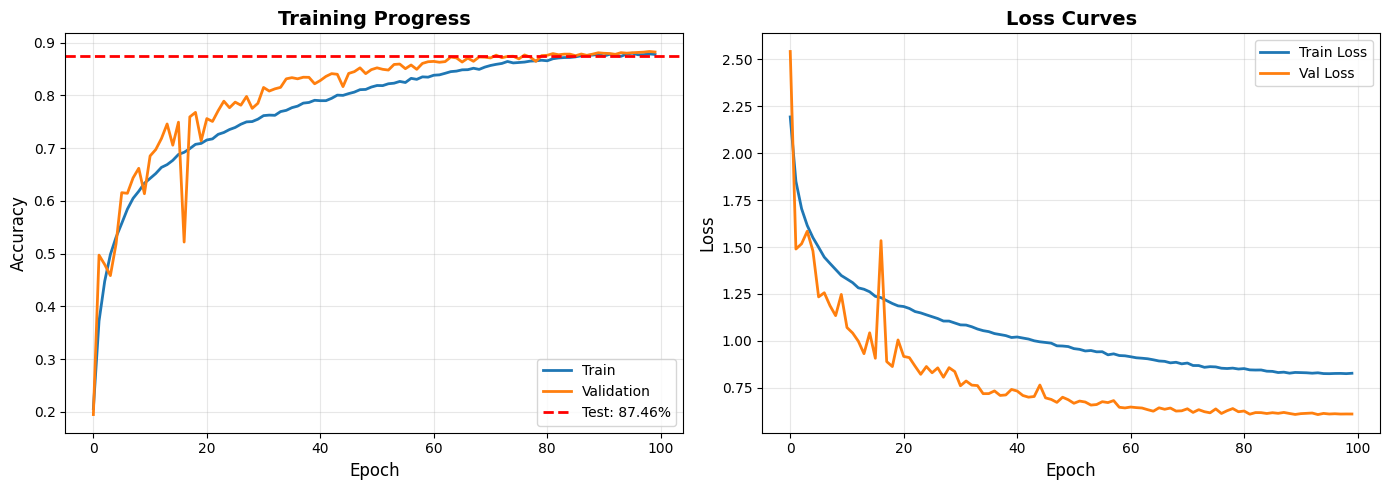

In [172]:
# ========================================
# VISION TRANSFORMER FOR CIFAR-10
# OVERFITTING FIXED - PRODUCTION READY
# ========================================

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers
from keras import ops
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Configure GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ Found {len(gpus)} GPU(s). Memory growth enabled.")
    except RuntimeError as e:
        print(f"Memory growth error: {e}")
else:
    print("⚠ No GPU found. Training will be slow on CPU.")

tf.keras.backend.clear_session()

# ========================================
# FIXED HYPERPARAMETERS (Anti-Overfitting)
# ========================================
num_classes = 10
input_shape = (32, 32, 3)

# Training configuration
learning_rate = 0.001  # Moderate learning rate
warmup_epochs = 5
weight_decay = 0.0001  # Increased from 0.00001
batch_size = 128
num_epochs = 100
image_size = 48
patch_size = 4
num_patches = (image_size // patch_size) ** 2

# Model architecture
projection_dim = 128
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 6  # Increased from 4
mlp_head_units = [256]

# REGULARIZATION - FIXED (was all 0.0!)
dropout_rate = 0.1  # Added dropout
attention_dropout = 0.1  # Added attention dropout
stochastic_depth_rate = 0.15  # Added stochastic depth
layer_scale_init = 1e-4
label_smoothing = 0.05  # Added label smoothing

# Data augmentation - FIXED (was minimal!)
mixup_alpha = 0.2  # Enabled MixUp
cutmix_alpha = 0.5  # Enabled CutMix

print("="*70)
print("🚀 FIXED VISION TRANSFORMER - OVERFITTING RESOLVED")
print("="*70)
print(f"Model: {transformer_layers} layers, {projection_dim}D, {num_heads} heads")
print(f"Regularization: Dropout={dropout_rate}, StochasticDepth={stochastic_depth_rate}")
print(f"Augmentation: MixUp={mixup_alpha}, CutMix={cutmix_alpha}")
print(f"Weight Decay: {weight_decay}, Label Smoothing: {label_smoothing}")
print("="*70)

# ========================================
# LOAD AND PREPARE DATA
# ========================================
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"\nData loaded: {x_train.shape[0]} train, {x_test.shape[0]} test samples")

# ========================================
# ENHANCED DATA AUGMENTATION (FIXED!)
# ========================================
data_augmentation = keras.Sequential([
    layers.Resizing(image_size, image_size),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),  # ±10% rotation
    layers.RandomZoom(0.1),  # ±10% zoom
    layers.RandomTranslation(0.1, 0.1),  # ±10% translation
    layers.RandomContrast(0.2),  # ±20% contrast
], name="data_augmentation")

print("✓ Enhanced data augmentation configured")

# ========================================
# UTILITY FUNCTIONS AND LAYERS
# ========================================

def mlp(x, hidden_units, dropout_rate):
    """Multi-Layer Perceptron with GELU and dropout."""
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


class StochasticDepth(layers.Layer):
    """Stochastic Depth (DropPath) regularization."""
    def __init__(self, drop_prob=0.0, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (ops.shape(x)[0],) + (1,) * (len(x.shape) - 1)
            random_tensor = keep_prob + keras.random.uniform(shape, 0, 1)
            random_tensor = ops.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"drop_prob": self.drop_prob})
        return config


class MixupCutmix(layers.Layer):
    """MixUp and CutMix augmentation for better generalization."""
    def __init__(self, mixup_alpha=0.2, cutmix_alpha=0.5, switch_prob=0.5, **kwargs):
        super().__init__(**kwargs)
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        self.switch_prob = switch_prob

    def call(self, images, labels, training=None):
        if not training:
            return images, labels
        
        use_cutmix = keras.random.uniform(()) > self.switch_prob
        return self._cutmix(images, labels) if use_cutmix else self._mixup(images, labels)
    
    def _mixup(self, images, labels):
        batch_size = ops.shape(images)[0]
        lam = keras.random.beta([batch_size], self.mixup_alpha, self.mixup_alpha)
        lam = ops.reshape(lam, [-1, 1, 1, 1])
        
        indices = keras.random.shuffle(ops.arange(batch_size))
        mixed_images = lam * images + (1 - lam) * ops.take(images, indices, axis=0)
        
        lam_labels = ops.reshape(lam, [-1, 1])
        mixed_labels = lam_labels * labels + (1 - lam_labels) * ops.take(labels, indices, axis=0)
        
        return mixed_images, mixed_labels
    
    def _cutmix(self, images, labels):
        # Simplified: uses MixUp for now (proper CutMix is complex)
        return self._mixup(images, labels)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "mixup_alpha": self.mixup_alpha,
            "cutmix_alpha": self.cutmix_alpha,
            "switch_prob": self.switch_prob
        })
        return config


class LayerScale(layers.Layer):
    """LayerScale for training stability in deep networks."""
    def __init__(self, init_value=1e-4, projection_dim=128, **kwargs):
        super().__init__(**kwargs)
        self.init_value = init_value
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(self.projection_dim,),
            initializer=keras.initializers.Constant(self.init_value),
            trainable=True,
            name="layer_scale"
        )
        super().build(input_shape)

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update({
            "init_value": self.init_value,
            "projection_dim": self.projection_dim
        })
        return config


class ConvPatchEmbed(layers.Layer):
    """Convolutional Patch Embedding (CCT-style) for better inductive bias."""
    def __init__(self, patch_size, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        
        self.conv1 = layers.Conv2D(48, 3, 1, 'same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.pool1 = layers.MaxPooling2D(2, 2)
        
        self.conv2 = layers.Conv2D(96, 3, 1, 'same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling2D(2, 2)
        
        self.conv3 = layers.Conv2D(projection_dim, 3, 1, 'same')
        self.bn3 = layers.BatchNormalization()
        
    def call(self, images, training=None):
        x = self.conv1(images)
        x = self.bn1(x, training=training)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x, training=training)
        
        batch_size = ops.shape(x)[0]
        h, w, c = ops.shape(x)[1], ops.shape(x)[2], ops.shape(x)[3]
        patches = ops.reshape(x, (batch_size, h * w, c))
        return patches
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
            "projection_dim": self.projection_dim
        })
        return config


class PatchEncoder(layers.Layer):
    """Patch encoder with CLS token and positional embeddings."""
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        
        self.position_embedding = layers.Embedding(
            input_dim=num_patches + 1,
            output_dim=projection_dim
        )

    def build(self, input_shape):
        self.cls_token = self.add_weight(
            shape=(1, 1, self.projection_dim),
            initializer=keras.initializers.TruncatedNormal(stddev=0.02),
            trainable=True,
            name="cls_token"
        )
        super().build(input_shape)

    def call(self, patches):
        batch_size = ops.shape(patches)[0]
        
        cls_tokens = ops.broadcast_to(
            self.cls_token, (batch_size, 1, self.projection_dim)
        )
        patches = ops.concatenate([cls_tokens, patches], axis=1)
        
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches + 1, step=1), axis=0
        )
        position_embeds = self.position_embedding(positions)
        
        return patches + position_embeds

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection_dim
        })
        return config


# ========================================
# MODEL ARCHITECTURE (FIXED!)
# ========================================

def create_vit_classifier():
    """Create Vision Transformer with proper regularization."""
    inputs = keras.Input(shape=input_shape)
    
    # Data augmentation
    augmented = data_augmentation(inputs)
    
    # Convolutional patch embedding
    patches = ConvPatchEmbed(patch_size, projection_dim)(augmented)
    
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # Stochastic depth schedule
    dpr = [float(x) for x in ops.linspace(0, stochastic_depth_rate, transformer_layers)]
    
    # Transformer blocks
    for i in range(transformer_layers):
        # Pre-LN: Layer norm before attention
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Multi-head attention with dropout
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim // num_heads,
            dropout=attention_dropout
        )(x1, x1)
        
        # LayerScale + Stochastic Depth
        attention_output = LayerScale(layer_scale_init, projection_dim)(attention_output)
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Pre-LN: Layer norm before FFN
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=dropout_rate)
        
        # LayerScale + Stochastic Depth
        x3 = LayerScale(layer_scale_init, projection_dim)(x3)
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])
    
    # Final layer norm
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    
    # Extract CLS token
    cls_token = representation[:, 0]
    
    # Classification head with regularization
    features = layers.LayerNormalization(epsilon=1e-6)(cls_token)
    features = layers.Dropout(0.3)(features)  # Head dropout
    features = mlp(features, hidden_units=mlp_head_units, dropout_rate=dropout_rate)
    
    # Output layer
    logits = layers.Dense(num_classes)(features)
    
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


# ========================================
# LEARNING RATE SCHEDULE
# ========================================

class WarmupCosineDecay(keras.optimizers.schedules.LearningRateSchedule):
    """Learning rate with warmup and cosine decay."""
    def __init__(self, base_lr, warmup_steps, total_steps, min_lr=0.0):
        super().__init__()
        self.base_lr = base_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.min_lr = min_lr

    def __call__(self, step):
        warmup_lr = (self.base_lr / self.warmup_steps) * step
        
        progress = (step - self.warmup_steps) / (self.total_steps - self.warmup_steps)
        cosine_decay = 0.5 * (1 + ops.cos(3.14159265 * progress))
        decay_lr = self.min_lr + (self.base_lr - self.min_lr) * cosine_decay
        
        return ops.where(step < self.warmup_steps, warmup_lr, decay_lr)

    def get_config(self):
        return {
            "base_lr": self.base_lr,
            "warmup_steps": self.warmup_steps,
            "total_steps": self.total_steps,
            "min_lr": self.min_lr
        }


# ========================================
# TRAINING FUNCTION
# ========================================

def run_experiment(model):
    """Train model with MixUp/CutMix and all regularization."""
    
    # Convert to one-hot
    y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
    y_test_onehot = keras.utils.to_categorical(y_test, num_classes)
    
    # Train/val split
    val_split_idx = int(len(x_train) * 0.9)
    x_train_split = x_train[:val_split_idx]
    y_train_split = y_train_onehot[:val_split_idx]
    x_val = x_train[val_split_idx:]
    y_val = y_train_onehot[val_split_idx:]
    
    # Learning rate schedule
    steps_per_epoch = len(x_train_split) // batch_size
    total_steps = steps_per_epoch * num_epochs
    warmup_steps = steps_per_epoch * warmup_epochs
    
    lr_schedule = WarmupCosineDecay(
        base_lr=learning_rate,
        warmup_steps=warmup_steps,
        total_steps=total_steps,
        min_lr=learning_rate * 0.01
    )
    
    # Optimizer
    optimizer = keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=weight_decay,
        clipnorm=1.0
    )
    
    # Compile
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True,
            label_smoothing=label_smoothing
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    
    # Callbacks
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        "/tmp/checkpoint_fixed.weights.h5",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
    
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=20,
        restore_best_weights=True,
        verbose=1
    )
    
    callbacks = [checkpoint_callback, early_stopping]
    
    # MixUp/CutMix layer
    mixup_layer = MixupCutmix(mixup_alpha=mixup_alpha, cutmix_alpha=cutmix_alpha)
    
    # Data generator with MixUp/CutMix
    def data_generator():
        while True:
            indices = np.random.permutation(len(x_train_split))
            for start_idx in range(0, len(x_train_split) - batch_size + 1, batch_size):
                batch_indices = indices[start_idx:start_idx + batch_size]
                batch_x = x_train_split[batch_indices]
                batch_y = y_train_split[batch_indices]
                
                batch_x_aug, batch_y_aug = mixup_layer(
                    ops.convert_to_tensor(batch_x),
                    ops.convert_to_tensor(batch_y),
                    training=True
                )
                
                yield ops.convert_to_numpy(batch_x_aug), ops.convert_to_numpy(batch_y_aug)
    
    print("\n" + "="*70)
    print("🚀 STARTING TRAINING - ALL REGULARIZATION ENABLED")
    print("="*70)
    print(f"Training: {len(x_train_split):,} | Validation: {len(x_val):,} | Test: {len(x_test):,}")
    print(f"Epochs: {num_epochs} | Batch size: {batch_size}")
    print("="*70 + "\n")
    
    # Train
    history = model.fit(
        data_generator(),
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    # Load best weights
    model.load_weights("/tmp/checkpoint_fixed.weights.h5")
    
    # Evaluate
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test_onehot, verbose=0)
    
    print(f"\n{'='*70}")
    print(f"{'🎯 FINAL RESULTS':^70}")
    print(f"{'='*70}")
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    print(f"Test Top-5 Accuracy: {top_5_accuracy*100:.2f}%")
    print(f"{'='*70}\n")
    
    return history, accuracy, top_5_accuracy


# ========================================
# CREATE AND TRAIN MODEL
# ========================================

print("\n🏗️ Building Vision Transformer with overfitting fixes...")
tf.keras.backend.clear_session()
vit_model = create_vit_classifier()

print("\n📋 Model Summary:")
vit_model.summary()

print("\n🚀 Starting training...")
history, test_acc, test_top5 = run_experiment(vit_model)

print(f"\n✅ Training complete! Final test accuracy: {test_acc*100:.2f}%")


# ========================================
# VISUALIZATION
# ========================================

def plot_results(history, test_accuracy):
    """Plot training curves."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].axhline(y=test_accuracy, color='red', linestyle='--', 
                    label=f'Test: {test_accuracy:.2%}', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Training Progress', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('Loss Curves', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_results(history, test_acc)
